### Predicting the acne severity level of input images

In [48]:
pretrained_model_name = 'ResNet152_ImageNet_Caffe.model'
pretrained_model_path = 'C:/Users/AyeshaP/Documents/Aceno/models'
pretrained_node_name = 'pool5' 

label_mapping = {1: '1-Clear', 2: '2-Almost Clear', 3: '3-Mild', 4: '4-Moderate', 5: '5-Severe'}

img_path = 'C:/Users/AyeshaP/Documents/Aceno/Resources/TestImages'

result_file = 'Test_lables.csv'
patch_path = 'Resources/Test_Im_patches'
regression_model_path = 'C:/Users/AyeshaP/Documents/Aceno/models/cntk_regression.dat'
Eye_Cascade_Path = 'C:/Users/AyeshaP/Documents/Aceno/models/haarcascade_eye.xml'
PREDICTOR_PATH = 'C:/Users/AyeshaP/Documents/Aceno/models/shape_predictor_68_face_landmarks.dat'

image_height = 224 
image_width  = 224 
num_channels = 3

verb = True 
width_ratio = 1.5 
top_ratio = 1.5   
down_ratio = 4.5  
cheek_width_ratio = 2.8 
forehead_ratio = 0.3 

In [49]:
from __future__ import print_function
import os
from os import listdir
from os.path import join, isfile, splitext
import numpy as np
import pandas as pd
import cntk as C
from PIL import Image
import pickle
import time
import json
from cntk import load_model, combine
import cntk.io.transforms as xforms
from cntk.logging import graph
from cntk.logging.graph import get_node_outputs
import cv2
import sys
import dlib
import imageio
import matplotlib.pyplot as plt

In [50]:
eye_cascade = cv2.CascadeClassifier(Eye_Cascade_Path) # Initialize the Eye cascade model


SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))



ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)


OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH) 

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)
    
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im


def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))


def infer_cheek_region(eye, width_ratio, down_ratio, left_or_right):
    region1 = [0] * 4
    if left_or_right == 'right': #assuming it is the absolute right chin
        region1[0] = int(max(0, int(eye[0] - 0.5 * eye[2]))) #cheek region should go lefwards
        region1[2] = int(0.5 * eye[2])
    else: # assuming it is the absolute left cheek
        region1[0] = int(eye[0] + eye[2]) # cheek region should go rightwards
        region1[2] = int(0.5 * eye[2])
    region1[1] = int(eye[1] + eye[3])
    region1[3] = int(1.5 * eye[3])
    return region1

def detect_face_direction(gray, face, eye, down_ratio, cheek_width_ratio):  
    region1 = [0] * 4 # assuming this is the left eye, forhead should go rightward
    region2 = [0] * 4 # assuming this is the right eye, forhead should go leftward
    region1 = infer_cheek_region(eye[0], cheek_width_ratio, down_ratio, 'left') #region1 is from eye to right
    region2 = infer_cheek_region(eye[0], cheek_width_ratio, down_ratio, 'right') # region2 is from eye to left
    std1 = np.std(gray[region1[1]:(region1[1]+region1[3]), region1[0]:(region1[0]+region1[2])])
    std2 = np.std(gray[region2[1]:(region2[1]+region2[3]), region2[0]:(region2[0]+region2[2])])
    face_direction = ""
    if std1 > std2:  #eye right has higher variance than eye left
        face_direction = "right"
    else:
        face_direction = "left"
    return face_direction

# Extract cheek patches based on face landmarks and eye landmarks, and whether it is left cheek or right cheek
def extract_cheek_region(face_x_min, face_x_max, face_y_max, eye_landmarks, left_or_right):
    if left_or_right == "Left":
        cheek_region_min_x = eye_landmarks[0,0] 
        cheek_region_max_x = int(face_x_max - 0.05 * (face_x_max - min(eye_landmarks[:,0])))
    else:
        cheek_region_max_x = eye_landmarks[-1, 0] 
                                                  
        cheek_region_min_x = int(face_x_min + 0.1 * (cheek_region_max_x - face_x_min)) 
    
    cheek_region_min_y = int(max(eye_landmarks[:,1]) + 0.2 * (max(eye_landmarks[:,1])  - min(eye_landmarks[:,1])))
    cheek_region_max_y = int(face_y_max - 0.1 * (face_y_max - max(eye_landmarks[:,1])))
    return [cheek_region_min_x, cheek_region_min_y, cheek_region_max_x, cheek_region_max_y]

0002
0003
0004
0005
0006
0007
Face not detected by landmarks model...
Right eye detected
0009
0010
0011
0012
0013
0015
0016
0017
0019
0020
0021
0022
0023
0024
0025
0026
0027
Face not detected by landmarks model...
Left eye detected
0028
0029
0030
0031
0032
0034
0035
0036
0037
0038
0039
0040
0041
0042
0043
Face not detected by landmarks model...
No cheeks or forehead detected, output the original file 0043.jpg
0044
0045
0046
0047
0048
0049
0050
0051
0052
0053
0054
0055
0056
0057
0058
0059
0060
0061
0062
0063
0064
0065
0066
0067
0068
0069
0070
Face not detected by landmarks model...
Right eye detected
0071
0072
0073
0074
0075
0076
0077
Face not detected by landmarks model...
Left eye detected
0078
Face not detected by landmarks model...
Right eye detected
0079
0080
Face not detected by landmarks model...
Left eye detected
0081
0082
Face not detected by landmarks model...
No cheeks or forehead detected, output the original file 0082.jpg
0083
Face not detected by landmarks model...
No chee

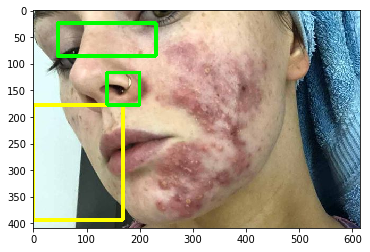

In [51]:
imageFiles = [join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f))]
num_images = len(imageFiles)
image_counter = 0


start_index = 0
end_index = num_images

for imagefile in imageFiles[start_index:end_index]:
    image_counter += 1
    imageName = splitext(os.path.basename(imagefile))[0] # Get the root name of the image  
                                                         # used to generate the skin patch file name.
   
    print(imageName)
    face_detected = False
    try:
        img, landmarks = read_im_and_landmarks(imagefile) 
        face_detected = True
    except:
        img = cv2.imread(imagefile)  
        face_detected = False
    img_height, img_width = img.shape[0:2] 
    min_dim = min(img_height, img_width)
    min_face_size = min_dim * 0.2  
    min_eye = min_face_size * 0.2  
    min_eye_area = min_eye ** 2  
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    
    if face_detected: 
        mask = get_face_mask(img, landmarks) 
        face_x_min = int(max(0, np.asarray(min(landmarks[:,0])).flatten()[0])) #Get the minimal value of the detected landmarks in x
        face_x_max = int(min(img_width, np.asarray(max(landmarks[:,0])).flatten()[0])) # Get the maximal value of the detected landmarks in x
        face_y_min = int(max(0, np.asarray(min(landmarks[:,1])).flatten()[0])) # Get the minimal value of the detected landmarks in y
        face_y_max = int(min(img_height, np.asarray(max(landmarks[:,1])).flatten()[0])) # Get the maximal value of the detected landmarks in y
        face_height = face_y_max - face_y_min # Get the height of face
        forehead_height = int(face_height * forehead_ratio) 
        new_face_y_min = max(0, face_y_min - forehead_height) 
        right_brow_landmarks = landmarks[RIGHT_BROW_POINTS,:]
        left_brow_landmarks = landmarks[LEFT_BROW_POINTS,:]
        right_eye_landmarks = landmarks[RIGHT_EYE_POINTS,:]
        left_eye_landmarks = landmarks[LEFT_EYE_POINTS,:]
        mouse_landmarks = landmarks[MOUTH_POINTS,:]
       
        # Get the forehead patch
      
        [right_brow_min_x, left_brow_max_x] = \
            [max(0, np.min(np.array(right_brow_landmarks[:,0]))), min(img_width, np.max(np.array(left_brow_landmarks[:,0])))]
        brow_min_y = min(np.min(np.array(right_brow_landmarks[:,1])),np.min(np.array(left_brow_landmarks[:,1])))
        forehead_x_min = right_brow_min_x # forehead starts at the left landmark of the right eye brow
        forehead_x_max = left_brow_max_x
        forehead_y_min = max(0, brow_min_y - forehead_height)
        forehead_y_max = min(brow_min_y, forehead_y_min + forehead_height)
        forehead_region = img[forehead_y_min:forehead_y_max, forehead_x_min:forehead_x_max, :]
        forehead_file_name = join(patch_path, imageName+"_fh.jpg")
        # BGR image needs to be converted to RGB before saving as image file
        forehead_region = cv2.cvtColor(forehead_region, cv2.COLOR_BGR2RGB)
        imageio.imwrite(forehead_file_name, forehead_region)
        
        chin_x_min = np.max(np.array(right_eye_landmarks[:,0])) #In x direction, chin patch will be between the two most inner
                                                                #points of eyebrows
        chin_x_max = np.min(np.array(left_eye_landmarks[:,0]))
        chin_y_min = np.max(np.array(mouse_landmarks[:,1])) #In y direction, chin patch starts at the lowest point of mouse landmarks
        chin_y_max = face_y_max # In y direction, chin patch ends at the lowest point of face
        chin_region = img[chin_y_min:chin_y_max, chin_x_min:chin_x_max, :]
        chin_file_name = join(patch_path, imageName+"_chin.jpg")
        chin_region = cv2.cvtColor(chin_region, cv2.COLOR_BGR2RGB)
        imageio.imwrite(chin_file_name, chin_region)
        
        
        # Get the cheeks patch
      
     
        left_eye_width = np.max(np.array(left_eye_landmarks[:,0])) - np.min(np.array(left_eye_landmarks[:,0]))
        right_eye_width = np.max(np.array(right_eye_landmarks[:,0])) - np.min(np.array(right_eye_landmarks[:,0]))
        right_face = True
        left_face = True
        if float(right_eye_width) / float(left_eye_width) >= 1.15: # right eye is bigger than left eye, showing the right face
            left_face = False
        elif float(left_eye_width) / float(right_eye_width) >= 1.15: # left eye is bigger than right eye, showing the left face
            right_face = False
        
        if right_face:
            right_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, right_eye_landmarks, "Right")
            cheek_region = img[right_cheek_region[1]:right_cheek_region[3], right_cheek_region[0]:right_cheek_region[2], :]
            cheek_file_name = join(patch_path, imageName+"_rc.jpg")
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            imageio.imwrite(cheek_file_name, cheek_region)
        if left_face:
            left_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, left_eye_landmarks, "Left")
            cheek_region = img[left_cheek_region[1]:left_cheek_region[3], left_cheek_region[0]:left_cheek_region[2], :]
            cheek_file_name = join(patch_path, imageName+"_lc.jpg")
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            imageio.imwrite(cheek_file_name, cheek_region)
        # if verb == True, display the detected skin patches on the original image, using rectangle to highlight the skin patches
        if verb:
            img_tmp = img
            img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
            cv2.rectangle(img_tmp, (forehead_x_min, forehead_y_min), (forehead_x_max, forehead_y_max), (0, 255, 0), 10)
            if right_face:
                cv2.rectangle(img_tmp, (right_cheek_region[0], right_cheek_region[1]), \
                              (right_cheek_region[2], right_cheek_region[3]), (255, 255, 0), 10)
            if left_face:
                cv2.rectangle(img_tmp, (left_cheek_region[0], left_cheek_region[1]), \
                              (left_cheek_region[2], left_cheek_region[3]), (255, 255, 0), 10)
            plt.imshow(img_tmp)
                
    if not face_detected:
        print("Face not detected by landmarks model...")
        # Use the OneEye model to detect one eye, and infer the face region based on the eye location
        eye_detected = False
        roi_gray = gray
        roi_color = img
        roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 5)
        max_area = 0
        eye_count = 0
        max_index = 0
        
        for (ex,ey,ew,eh) in eyes: # there might be multiple eyes detected. Choose the biggest one
            if ew*eh >= max_area and ex >= img_width * 0.1 and ex <= img_width * 0.9:
                max_area = ew*eh
                max_index = eye_count
            eye_count += 1
        if max_area >= min_eye_area: # if area of maximal eye is greater than the eye area threshold, take it as a real eye
            eye_detected = True
            (ex, ey, ew, eh) = eyes[max_index]
            if float(ew) / float(img_width) > 0.15 or float(eh) / float(img_height) > 0.15: # detected eye too large
                # resize the detected eye
                center_x = ex + ew/2
                center_y = ey + eh/2
                resized_w = min(img_width * 0.15, img_height * 0.15) # resize the eye
                ex = int(center_x - resized_w/2)
                ey = int(center_y - resized_w/2)
                ew = int(resized_w)
                eh = int(resized_w)
                eyes1 = np.array([ex, ey, resized_w, resized_w]).reshape((1,4))
            else:
                eyes1 = np.array(eyes[max_index]).reshape((1,4))
            face1 = np.array(())
            face_direction = detect_face_direction(gray, face1, eyes1, down_ratio, cheek_width_ratio)
            if face_direction == "left":
                print("Left eye detected")
                face_min_x = eyes1[0, 0]
                face_max_x = min(img_width, int(eyes1[0,0] + (cheek_width_ratio + 0.5) * eyes1[0, 2]))
                forehead_max_x = min(img_width, int(eyes1[0,0] + width_ratio * eyes1[0, 2]))
                forehead_min_x = face_min_x
                cheek_min_x = int(eyes1[0, 0] + 0.5 * eyes1[0,2])
                cheek_max_x = face_max_x
            else:
                print("Right eye detected")
                face_min_x = max(0, int(eyes1[0, 0] - cheek_width_ratio * eyes1[0, 2]))
                face_max_x = eyes1[0, 0] + eyes1[0, 2]
                forehead_min_x = max(0, int(eyes1[0, 0] - width_ratio * eyes1[0, 2]))
                forehead_max_x = min(img_width, int(eyes1[0, 0] + width_ratio * eyes1[0, 2]))   
                cheek_max_x = int(eyes1[0,0] + 0.5*eyes1[0,2])
                cheek_min_x = face_min_x
            forehead_min_y = max(0, int(eyes1[0, 1] - top_ratio * eyes1[0,3]))
            forehead_max_y = max(0, int(eyes1[0, 1] - 0.5 * eyes1[0, 3]))
            forehead_ok = False
            # Get the forehead region
            if forehead_max_y - forehead_min_y >= 0.7 * eyes1[0, 3]:
                forehead_ok = True
                forehead_region = img[forehead_min_y:forehead_max_y, forehead_min_x: forehead_max_x, :]
                forehead_region = cv2.cvtColor(forehead_region, cv2.COLOR_BGR2RGB)
                forehead_file_name = join(patch_path, imageName+"_fh.jpg")
                imageio.imwrite(forehead_file_name, forehead_region)
            # Get the cheek region
            cheek_min_y = int(eyes1[0, 1] + eyes1[0, 3])
            cheek_max_y = min(img_height, int(eyes1[0, 1] + down_ratio * eyes1[0, 3]))
            cheek_region = img[cheek_min_y: cheek_max_y, cheek_min_x: cheek_max_x, :]
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            if face_direction == "left":
                cheek_file_name = join(patch_path, imageName+"_lc.jpg")
            elif face_direction == "right":
                cheek_file_name = join(patch_path, imageName+"_rc.jpg")
            else:
                cheek_file_name = join(patch_path, imageName+"_c.jpg")
            imageio.imwrite(cheek_file_name, cheek_region)
            if verb:
                image = img
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if forehead_ok:
                    cv2.rectangle(image, (forehead_min_x, forehead_min_y), \
                                  (forehead_max_x, forehead_max_y), (0, 255, 0), 5)
                cv2.rectangle(image, (cheek_min_x, cheek_min_y), \
                              (cheek_max_x, cheek_max_y), (255, 255, 0), 5)
                cv2.rectangle(image,(ex,ey),(ex+ew,ey+eh), (0,255,0), 5)
                               
                plt.imshow(image)
                #plt.imshow(roi_color)
    if (not face_detected) and (not eye_detected): # no face detected, nor eye detected, save the entire image and write to dest
        print("No cheeks or forehead detected, output the original file %s.jpg"%imageName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if verb:
            plt.imshow(img)
        outfile = join(patch_path, imageName+".jpg")
        imageio.imwrite(outfile, img)

    

In [52]:
model_file  = os.path.join(pretrained_model_path, pretrained_model_name)
loaded_model  = load_model(model_file)
node_in_graph = loaded_model.find_by_name(pretrained_node_name)
output_nodes  = combine([node_in_graph.owner])

node_outputs = C.logging.get_node_outputs(loaded_model)
for l in node_outputs: 
    if l.name == pretrained_node_name:
        num_nodes = np.prod(np.array(l.shape))
        
print ('the pretrained model is %s' % pretrained_model_name)
print ('the selected layer name is %s and the number of flatten nodes is %d' % (pretrained_node_name, num_nodes))

the pretrained model is ResNet152_ImageNet_Caffe.model
the selected layer name is pool5 and the number of flatten nodes is 2048


In [53]:
def extract_features(image_path):   
    img = Image.open(image_path)       
    resized = img.resize((image_width, image_height), Image.ANTIALIAS)  
    
    bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]    
    hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2)) 
    
    arguments = {loaded_model.arguments[0]: [hwc_format]}    
    output = output_nodes.eval(arguments)   
    return output

In [54]:
#load the stored regression model
read_model = pd.read_pickle(regression_model_path)
regression_model = read_model['model'][0]
train_regression = pickle.loads(regression_model)

In [55]:
patch_score = dict()
for file in next(os.walk(patch_path))[2]:
    file_path = os.path.join(patch_path, file)
    # extract features from CNTK pretrained model
    score_features = extract_features (file_path)[0].flatten()
    # score the extracted features using trained regression model
    pred_score_label = train_regression.predict(score_features.reshape(1,-1))
    patch_score[file] = float("{0:.2f}".format(pred_score_label[0]))

In [56]:
patch_score

{'0002_chin.jpg': 1.42,
 '0002_fh.jpg': 1.91,
 '0002_lc.jpg': 1.55,
 '0002_rc.jpg': 1.8,
 '0003_chin.jpg': 2.87,
 '0003_fh.jpg': 2.6,
 '0003_lc.jpg': 4.0,
 '0004_chin.jpg': 1.89,
 '0004_fh.jpg': 1.93,
 '0004_lc.jpg': 1.32,
 '0005_chin.jpg': 3.1,
 '0005_fh.jpg': 2.99,
 '0005_lc.jpg': 2.8,
 '0005_rc.jpg': 3.7,
 '0006_chin.jpg': 2.88,
 '0006_fh.jpg': 1.37,
 '0006_lc.jpg': 2.35,
 '0006_rc.jpg': 2.88,
 '0007_fh.jpg': 2.16,
 '0007_rc.jpg': 4.04,
 '0009_chin.jpg': 2.16,
 '0009_fh.jpg': 2.11,
 '0009_lc.jpg': 1.62,
 '0009_rc.jpg': 2.32,
 '0010_chin.jpg': 1.19,
 '0010_fh.jpg': 0.84,
 '0010_lc.jpg': 0.94,
 '0010_rc.jpg': 1.39,
 '0011_chin.jpg': 1.17,
 '0011_fh.jpg': 2.99,
 '0011_lc.jpg': 2.3,
 '0011_rc.jpg': 1.06,
 '0012_chin.jpg': 4.2,
 '0012_fh.jpg': 4.34,
 '0012_rc.jpg': 5.01,
 '0013_chin.jpg': 3.19,
 '0013_fh.jpg': 3.74,
 '0013_lc.jpg': 3.97,
 '0013_rc.jpg': 4.09,
 '0015_chin.jpg': 3.91,
 '0015_fh.jpg': 5.07,
 '0015_rc.jpg': 4.14,
 '0016_chin.jpg': 5.67,
 '0016_fh.jpg': 0.97,
 '0016_rc.jpg': 

In [57]:
# Predict Image label
image_patch_scores = {}
for key in patch_score:
    image_id = key[0:5]
    image_patch_scores_i = image_patch_scores.get(image_id, {"patch_name":[], "patch_score":[]})
    image_patch_scores_i["patch_name"].append(key)
    image_patch_scores_i["patch_score"].append(patch_score[key])
    image_patch_scores[image_id] = image_patch_scores_i

fp = open(result_file, 'w')
fp.write("Image_Name, Predicted_Label_Avg, Predicted_Label, Most_Severe_Patch\n")

for key in image_patch_scores:
    image_name = key + ".jpg"
    max_index = np.argmax(image_patch_scores[key]['patch_score'])
    Predicted_Label_Avg = np.mean(image_patch_scores[key]['patch_score'])
    if Predicted_Label_Avg > 0.4 and Predicted_Label_Avg <= 1.5:
        Predicted_Label = "Clear"
    elif Predicted_Label_Avg > 1.5 and Predicted_Label_Avg <= 2.5:
        Predicted_Label = "Almost Clear"

    elif Predicted_Label_Avg > 2.5 and Predicted_Label_Avg <= 3.5:
        Predicted_Label = "Mild"

    elif Predicted_Label_Avg > 3.5 and Predicted_Label_Avg <= 4.5:
        Predicted_Label = "Moderate"

    elif Predicted_Label_Avg > 4.5 and Predicted_Label_Avg <= 5.5:
        Predicted_Label = "Severe"
    else:
        Predicted_Label = "Undefined"
        
    Most_Severe_Patch = image_patch_scores[key]['patch_name'][max_index]
    print(Predicted_Label)
    fp.write('%s, %.4f, %s, %s\n'%(image_name, Predicted_Label_Avg, Predicted_Label, Most_Severe_Patch))

fp.close()

Almost Clear
Mild
Almost Clear
Mild
Almost Clear
Mild
Almost Clear
Clear
Almost Clear
Severe
Moderate
Moderate
Mild
Mild
Moderate
Mild
Mild
Almost Clear
Almost Clear
Mild
Mild
Almost Clear
Moderate
Almost Clear
Moderate
Almost Clear
Moderate
Mild
Clear
Almost Clear
Almost Clear
Almost Clear
Mild
Almost Clear
Almost Clear
Severe
Almost Clear
Moderate
Moderate
Almost Clear
Almost Clear
Almost Clear
Moderate
Almost Clear
Mild
Moderate
Moderate
Mild
Moderate
Almost Clear
Almost Clear
Almost Clear
Almost Clear
Clear
Mild
Almost Clear
Almost Clear
Clear
Almost Clear
Almost Clear
Almost Clear
Almost Clear
Mild
Moderate
Mild
Mild
Mild
Moderate
Moderate
Clear
Almost Clear
Moderate
Severe
Mild
Mild
Moderate
Mild
Moderate
Moderate
Moderate
Mild
Moderate
Moderate
Mild
Moderate
Almost Clear
Moderate
Mild
Moderate
Mild
Severe
Mild
Almost Clear
Mild
Moderate
Moderate
Moderate
Moderate
Mild
Almost Clear
